# Analyzing the database, what is the type of audience (considering gender and age) and the ideal channel to sell a certain type of product?

Nome: Matheus Ribeiro Cerqueira

Linkedin: https://www.linkedin.com/in/matheusrc/

GitHub: https://github.com/mathewsrc/

Últimos projetos:

Criação de uma aplicação baseada em Generative AI para auxiliar candidatos na compreensão de editais de concursos. O projeto utiliza alguns dos conceitos de MLOps como CI/CD, Infrastructure as Code e diversos serviços da AWS como Lambda Functions, S3, ECR, ECS, Bedrock, etc.
- https://github.com/mathewsrc/generativeai-questions-and-answers-app

Pipeline de ETL com dados públicos sobre lincesas. No projeto foi utilizado o Airflow para orquestração e os serviço do Google Cloud BigQuery e Looker para análise.
- https://github.com/mathewsrc/ETL-Chicago-Cafe-Permits

Projeto de Natural Language Processing que utilizou dados de reclamações no Brasil para indentificar os principais motivos das reclamações dos consumudores brasileiros
- https://github.com/mathewsrc/Topic-Modeling-Reclame-Aqui

Projeto de aprendizado de máquina para construir um modelo de classificação multiclasse para prever o tipo de "cultura" enquanto usa técnicas para evitar a multicolinearidade das features.
- https://github.com/mathewsrc/predictive-modeling-for-agriculture

In [19]:
!pip install -q polars=='0.20.30'
!pip install -q scikit-learn=='1.5.0'
!pip install -q matplotlib=='3.9.0'
!pip install -q seaborn=='0.13.2'
!pip install -q scipy=='1.13.1'

In [25]:
import seaborn as sns
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import numpy as np
import os
from zipfile import ZipFile
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Business Understanding

Business objective

- Which ideally type of audience and channel for each product category?


## Data Understanding

Extract zip file

In [21]:
zip_path = 'archive.zip'
zip_output_dir = '/content/'
with ZipFile(zip_path, 'r') as zip_f:
  zip_f.extractall(zip_output_dir)

Import CSV

In [22]:
filename = 'Ecommerce_DBS.csv'
ecommerce = pl.read_csv(os.path.join(zip_output_dir, filename),
                        try_parse_dates=True)
ecommerce.head(3)

Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,NPS,Customer Age,Gender,Source,Country,State,Latitude,Longituide
i64,date,str,i64,i64,i64,i64,i64,str,str,str,str,str,f64
46251,2020-09-08,"""Electronics""",12,3,740,7,20,"""Male""","""Instagram Campign""","""Canada""","""Alberta""","""55.000000""",-115.0
46251,2022-03-05,"""Home""",468,4,2739,8,20,"""Male""","""Instagram Campign""","""Canada""","""Ontario""","""50.000000""",-85.0
46251,2022-05-23,"""Home""",288,2,3196,10,20,"""Male""","""SEM""","""United States""","""New Mexico""","""34.840515""",-106.248482


In [23]:
ecommerce.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Customer ID            250000 non-null  int64         
 1   Purchase Date          250000 non-null  datetime64[ms]
 2   Product Category       250000 non-null  object        
 3   Product Price          250000 non-null  int64         
 4   Quantity               250000 non-null  int64         
 5   Total Purchase Amount  250000 non-null  int64         
 6   NPS                    250000 non-null  int64         
 7   Customer Age           250000 non-null  int64         
 8   Gender                 250000 non-null  object        
 9   Source                 250000 non-null  object        
 10  Country                250000 non-null  object        
 11  State                  250000 non-null  object        
 12  Latitude               250000 non-null  obje

In [24]:
ecommerce.describe()

statistic,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,NPS,Customer Age,Gender,Source,Country,State,Latitude,Longituide
str,f64,str,str,f64,f64,f64,f64,f64,str,str,str,str,str,f64
"""count""",250000.0,"""250000""","""250000""",250000.0,250000.0,250000.0,250000.0,250000.0,"""250000""","""250000""","""250000""","""250000""","""250000""",250000.0
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0
"""mean""",25004.03624,"""2021-11-06""",null,254.659512,2.998896,2725.370732,4.991832,43.759228,null,null,null,null,null,-81.648522
"""std""",14428.27959,null,null,141.568577,1.414694,1442.933565,3.166732,15.392075,null,null,null,null,null,37.33911
"""min""",1.0,"""2020-01-01""","""Books""",10.0,1.0,100.0,0.0,18.0,"""Female""","""FaceBook campaign""","""Canada""","""Alabama""",""" 36.116203""",-127.647621
"""25%""",12498.0,"""2020-12-02""",null,132.0,2.0,1477.0,2.0,30.0,null,null,null,null,null,-106.0
"""50%""",25018.0,"""2021-11-06""",null,255.0,3.0,2724.0,5.0,44.0,null,null,null,null,null,-74.948051
"""75%""",37506.0,"""2022-10-11""",null,377.0,4.0,3974.0,8.0,57.0,null,null,null,null,null,-74.948051
"""max""",50000.0,"""2023-09-15""","""Home""",500.0,5.0,5350.0,10.0,70.0,"""Male""","""SEM""","""United States""",""" Kansas""","""55""",98.739075


## Data cleaning

In [7]:
def rename_columns(df):
  old_columns = df.columns
  new_columns = [colname.strip().lower().replace(' ', '_') for colname in old_columns]
  mapping = dict(zip(old_columns, new_columns))
  df = df.rename(mapping)
  return df

In [8]:
def cleaning(df):
  ecommerce_c = rename_columns(df)
  ecommerce_c = ecommerce_c.drop_nulls()
  ecommerce_c = ecommerce_c.drop('customer_id')
  ecommerce_c = ecommerce_c.unique()
  ecommerce_c = ecommerce_c.with_columns(
      pl.col('latitude').str.strip_chars().cast(pl.Float64))
  return ecommerce_c

In [9]:
def feature_engineering(df):
  ecommerce_c = df.with_columns(
      product_price = pl.col('product_price').cast(pl.Float64),
      revenue = (pl.col('quantity') * pl.col('product_price').cast(pl.Float64)).cast(pl.Float64),
      year = (pl.col('purchase_date').dt.year().cast(pl.Int64)),
      month = (pl.col('purchase_date').dt.month().cast(pl.Int64))
  )
  bins = [29, 39, 49, 59, 69]
  labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
  ages = ecommerce_c['customer_age']
  ecommerce_c = ecommerce_c.with_columns(age_group=ages.cut(breaks=bins,
                                                          labels=labels))
  return ecommerce_c

In [10]:
ecommerce_c = cleaning(ecommerce)
ecommerce_c = feature_engineering(ecommerce_c)
ecommerce_c.head(3)

purchase_date,product_category,product_price,quantity,total_purchase_amount,nps,customer_age,gender,source,country,state,latitude,longituide,revenue,year,month,age_group
date,str,f64,i64,i64,i64,i64,str,str,str,str,f64,f64,f64,i64,i64,cat
2020-04-22,"""Clothing""",167.0,4,466,10,52,"""Male""","""FaceBook campaign""","""Canada""","""Nova""",45.0,-63.0,668.0,2020,4,"""50-59"""
2022-08-21,"""Books""",355.0,3,3786,10,48,"""Male""","""Organic Search""","""United States""","""Louisiana""",31.169546,-91.867805,1065.0,2022,8,"""40-49"""
2023-03-02,"""Books""",470.0,4,3912,9,30,"""Female""","""Organic Search""","""United States""","""California""",36.116203,-119.681564,1880.0,2023,3,"""30-39"""


## Data Analysis Exploration

In [11]:
sql = pl.SQLContext(ecommerce=ecommerce_c, eager_execution=True)

In [12]:
#plt.rc('font', size=12)
#plt.rc('legend', fontsize=8)

### What is the most sold and least sold product category? What is the most and least expensive category?


In [13]:
most_sold_least_sold = sql.execute(
"""
SELECT
  product_category,
  SUM(quantity) AS total
FROM ecommerce
GROUP BY 1
ORDER BY total DESC
"""
)

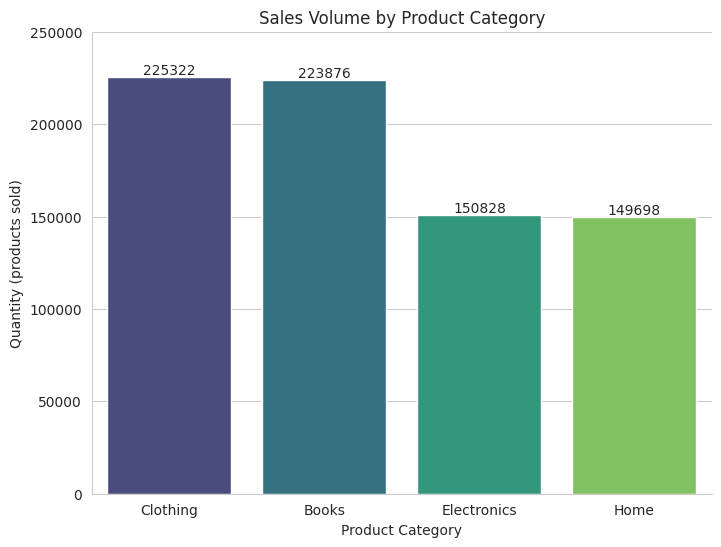

In [14]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="product_category", y="total",hue='product_category',
                 palette='viridis',
                 data=most_sold_least_sold.to_pandas())
plt.title('Sales Volume by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Quantity (products sold)')
sns.despine()
plt.ylim(top=250000)

for i in ax.containers:
    ax.bar_label(i,)
plt.show()

Based on the 'Sales Volume by Product Category' chart  shows that the categories clothing (225322) and books (223876) were the most sold.

### What are the best-selling products over the last 3 years?

In [15]:
best_selling_over_3_years = sql.execute("""
SELECT
  DISTINCT(product_category), SUM(quantity)
FROM (
  SELECT *
  FROM ecommerce
  WHERE EXTRACT(YEAR FROM purchase_date) > MAX(EXTRACT(YEAR FROM purchase_date)) - 3
  ) AS t1
GROUP BY product_category
ORDER BY quantity DESC
""")

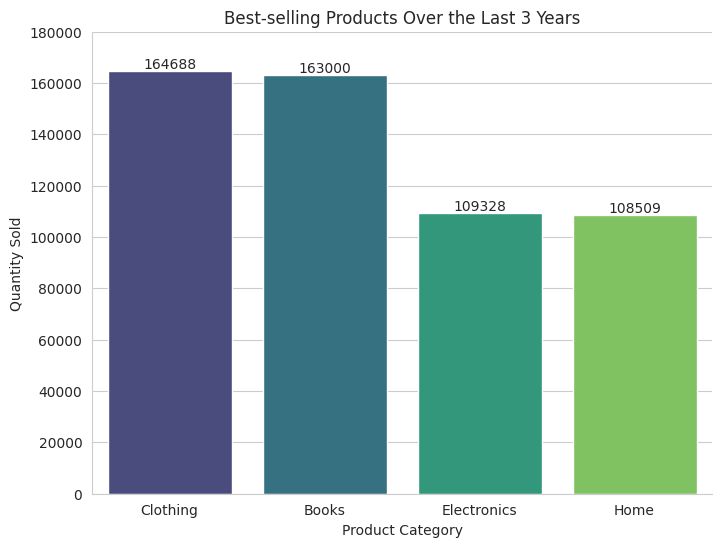

In [16]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.barplot(x='product_category', y='quantity',
                 hue='product_category',
                 palette='viridis',
                 data=best_selling_over_3_years.to_pandas())
plt.xlabel('Product Category')
plt.ylabel('Quantity Sold')
plt.title('Best-selling Products Over the Last 3 Years')
sns.despine()
plt.ylim(top=180000)

for i in ax.containers:
    ax.bar_label(i,)
plt.show()

Over the last 3 years clothing (164,688 Units) and books (163000 Units) product category have the best result in terms of quantity sold.

### What is the most expensive and cheapest product?

In [66]:
most_cheapest_product = sql.execute("""
SELECT
  product_category,
  MIN(product_price) AS min_price,
  MAX(product_price) AS max_price
FROM ecommerce
GROUP BY 1
""")

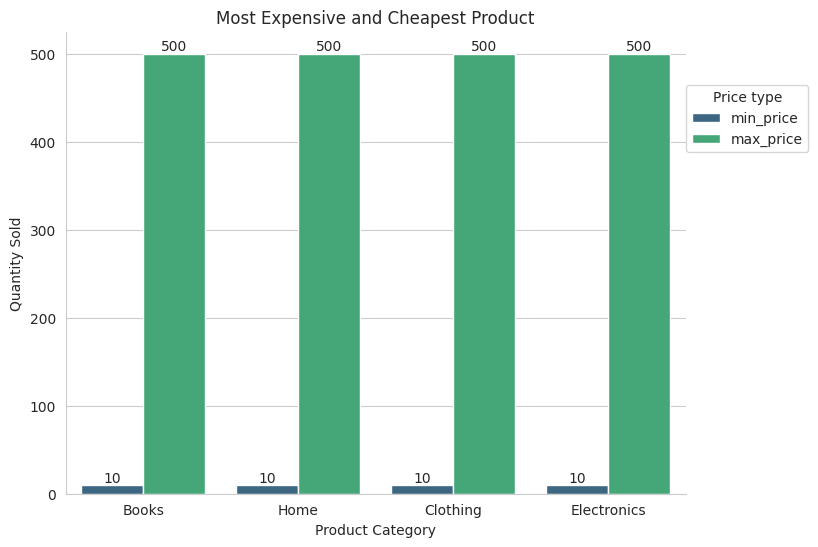

In [92]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
df_melted = most_cheapest_product.melt(id_vars="product_category",
                                       value_vars=cs.numeric(),
                                       value_name='price',
                                       variable_name='price_type')
ax = sns.barplot(x='product_category', y="price",
                 hue="price_type",
                 palette='viridis',
                 data=df_melted.to_pandas())
plt.xlabel('Product Category')
plt.ylabel('Quantity Sold')
plt.title('Most Expensive and Cheapest Product')
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.99, .90), title='Price type')
sns.despine()

for i in ax.containers:
    ax.bar_label(i,)
plt.show()

The chart reveals that all categories share a minimum price of 10 dollars and maximum of 500 dollars. Therefore, we can not conclude conclude what are the most expensive and the cheapest product.

**Tukey's HSD (Honestly Significant Difference) test for 'Revenue' across different categories**

- Null Hypothesis (H0): There is no significant difference between the means of the groups (categories) being compared.

- Alternative Hypothesis (H1): There is at least one pair of groups (categories) with significantly different means.

In [26]:
# Tukey's HSD test for 'Revenue' across different categories, with
# significance of 5% (alpha)
model = ols('revenue ~ product_category', data=ecommerce_c.to_pandas()).fit()
tukey_result = sm.stats.multicomp.pairwise_tukeyhsd(
    endog=ecommerce_c.to_pandas()['revenue'],
    groups=ecommerce_c.to_pandas()['product_category'],
    alpha=0.05)
print("\nTukey's HSD test results for Revenue across different Product Category:")
print(tukey_result)


Tukey's HSD test results for Revenue across different Product Category:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
      Books    Clothing   2.3272 0.8717 -5.5224 10.1769  False
      Books Electronics   5.2712 0.4108 -3.4963 14.0387  False
      Books        Home   4.9458 0.4704 -3.8392 13.7309  False
   Clothing Electronics    2.944 0.8239 -5.8202 11.7082  False
   Clothing        Home   2.6186 0.8698 -6.1632 11.4004  False
Electronics        Home  -0.3254 0.9998 -9.9364  9.2856  False
--------------------------------------------------------------


Based on the results of Tukey's HSD test for Revenue across different categories:

There are no significant differences in mean revenue between any pair of categories, as indicated by the "reject" column, which shows "False" for all pairs.
The p-values for all pairwise comparisons are above the significance level of 0.05 (or 5%), suggesting that we fail to reject the null hypothesis of equal means.
Therefore, we cannot conclude that there are any significant differences in mean revenue between the categories.

### What is the most sold and least sold product by source?


In [27]:
most_sold_least_sold = sql.execute(
"""
SELECT
  source,
  SUM(quantity) AS total
FROM ecommerce
GROUP BY 1
ORDER BY total DESC
"""
)

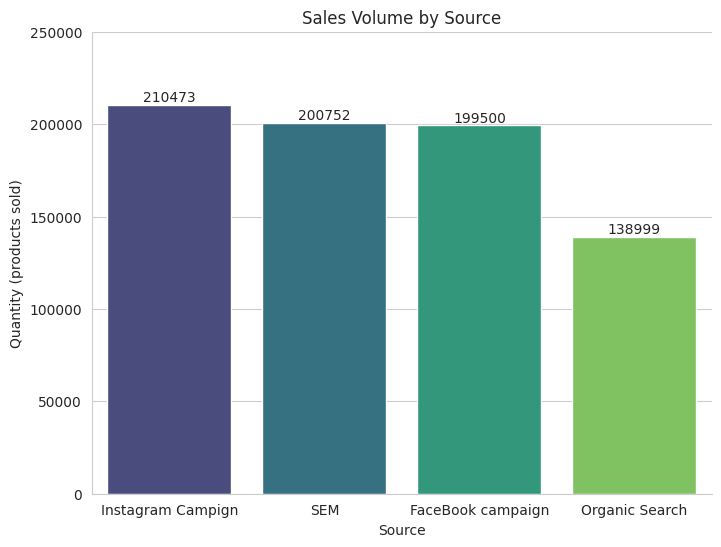

In [93]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="source", y="total",
                 hue='source',
                 palette='viridis',
                 data=most_sold_least_sold.to_pandas())
plt.title('Sales Volume by Source')
plt.xlabel('Source')
plt.ylabel('Quantity (products sold)')
sns.despine()
plt.ylim(top=250000)

for i in ax.containers:
    ax.bar_label(i,)
plt.show()

Based on the 'Sales volume by origin' chart, the best-performing channels were Instagram Campaign (210,473 units sold) and Organic Search (138,999 units sold), while the worst-performing channel was Organic Search.

**Tukey's HSD (Honestly Significant Difference) test for 'Revenue' across different sources**

- Null Hypothesis (H0): There is no significant difference between the means of the groups (sources) being compared.

- Alternative Hypothesis (H1): There is at least one pair of groups (sources) with significantly different means.

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Tukey's HSD test for 'Revenue' across different sources, with
# significance of 5% (alpha)
model = ols('revenue ~ source', data=ecommerce_c.to_pandas()).fit()
tukey_result = sm.stats.multicomp.pairwise_tukeyhsd(
    endog=ecommerce_c.to_pandas()['revenue'],
    groups=ecommerce_c.to_pandas()['source'],
    alpha=0.05)
print("\nTukey's HSD test results for Revenue across different Source:")
print(tukey_result)


Tukey's HSD test results for Revenue across different Source:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------
FaceBook campaign Instagram Campign   0.7887 0.9947  -7.4282  9.0055  False
FaceBook campaign    Organic Search   7.7405 0.1335  -1.4505 16.9315  False
FaceBook campaign               SEM   2.7265 0.8344  -5.5925 11.0456  False
Instagram Campign    Organic Search   6.9518 0.2022  -2.1476 16.0512  False
Instagram Campign               SEM   1.9379 0.9303  -6.2799 10.1556  False
   Organic Search               SEM   -5.014 0.4984 -14.2058  4.1778  False
---------------------------------------------------------------------------


Based on the results of Tukey's HSD test for Revenue across different sources:

There are no significant differences in mean revenue between any pair of sources, as indicated by the "reject" column, which shows "False" for all pairs.
The p-values for all pairwise comparisons are above the significance level of 0.05 (or 5%), suggesting that we fail to reject the null hypothesis of equal means.
Therefore, we cannot conclude that there are any significant differences in mean revenue between the sources.

### Which product has the best and worst NPS?

In [30]:
avg_nps_by_category = sql.execute(
    """
    SELECT
      product_category, AVG(nps) AS avg_nps
    FROM ecommerce
    GROUP BY product_category
    ORDER BY avg_nps
    """
)

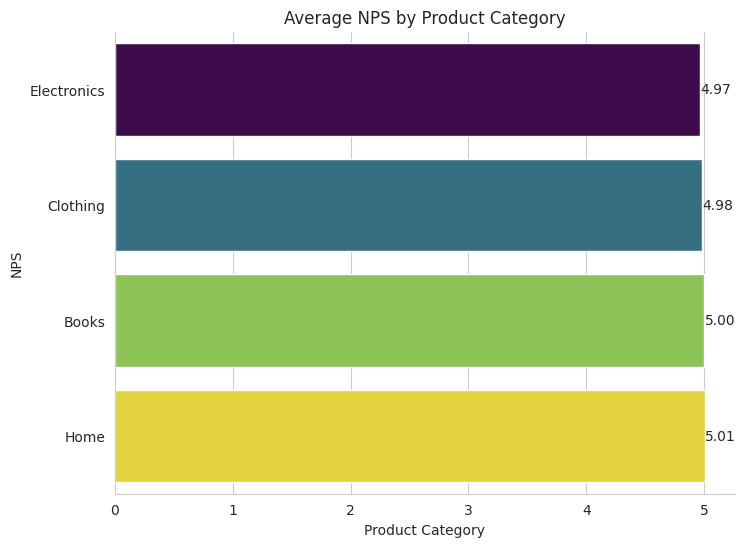

In [31]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(y='product_category', x='avg_nps',
                 hue="avg_nps",
                 legend=False,
                 palette='viridis',
                 orient = 'h',
                 data=avg_nps_by_category.to_pandas())
plt.title('Average NPS by Product Category')
plt.xlabel('Product Category')
plt.ylabel('NPS')
sns.despine()

for i in ax.containers:
    ax.bar_label(i, label_type='edge', fmt='%.2f')
plt.show()

Based on the 'Average NPS by Product Category' chart in average the home category has slightly the best satisfaction factor of the customer (NPS). So, we can not conclude what product category have the best NPS just by the mean.

### How many products were sold by gender?

In [32]:
quantity_by_gender = sql.execute(
"""
SELECT
  gender,
  SUM(quantity) AS total
FROM ecommerce
GROUP BY gender
ORDER BY total DESC
""")

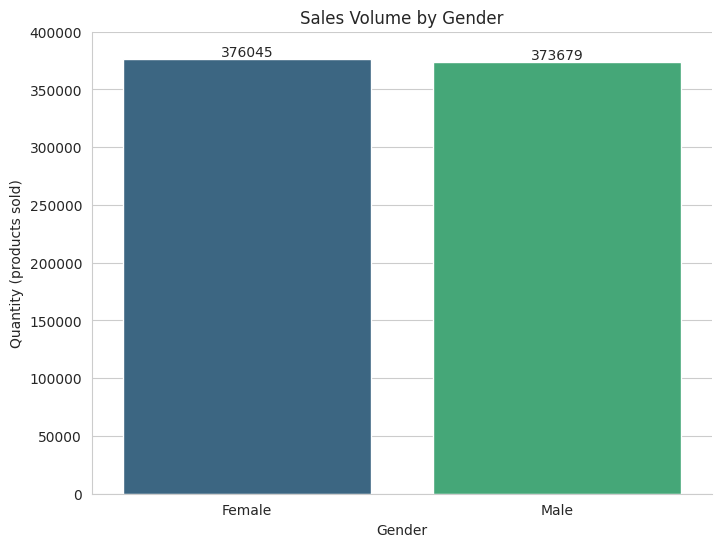

In [33]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="gender", y="total",
                 hue="gender",
                 palette='viridis',
                 data=quantity_by_gender.to_pandas())
plt.title('Sales Volume by Gender')
plt.xlabel('Gender')
plt.ylabel('Quantity (products sold)')
sns.despine()
plt.ylim(top=400000)

for i in ax.containers:
    ax.bar_label(i,)
plt.show()

**Independent two-sample t-test for Revenue based on Gender**

Null hyphotesis: There is no association between gender and quantity.

Alternative hyphotesis: There is an association between gender and quantity.

In [34]:
male_quantity = ecommerce_c.filter(pl.col('gender') == 'Male').select('revenue')
female_quantity = ecommerce_c.filter(pl.col('gender') == 'Female').select('revenue')

t_statistic, p_value = stats.ttest_ind(male_quantity,
                                       female_quantity,
                                       random_state=42)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Check significance
alpha = 0.05
if p_value < alpha: # If 𝑝 -value < 𝛼: Reject 𝐻0​. Accept 𝐻1​.
    print("There is a statistically significant difference between genders.")
else: # If 𝑝 -value ≥ 𝛼: Fail to reject 𝐻0​. No evidence to support 𝐻 1
    print("There is no statistically significant difference between genders.")

T-statistic: [1.14845231]
P-value: [0.25078299]
There is no statistically significant difference between genders.


Based on the 'Sales Volume by Gender' chart, the quantity of product sold by gender is almost the same. The 'Independent two-sample t-test for Revenue based on Gender' confirm that there no association of quantity by gender.

### How customer are distributed by age and gender?

In [35]:
total_customers_by_age_group = sql.execute(
    """
    SELECT
      gender,
      age_group,
      COUNT(gender) AS total
    FROM ecommerce
    GROUP BY gender, age_group
    ORDER BY age_group ASC
    """
)

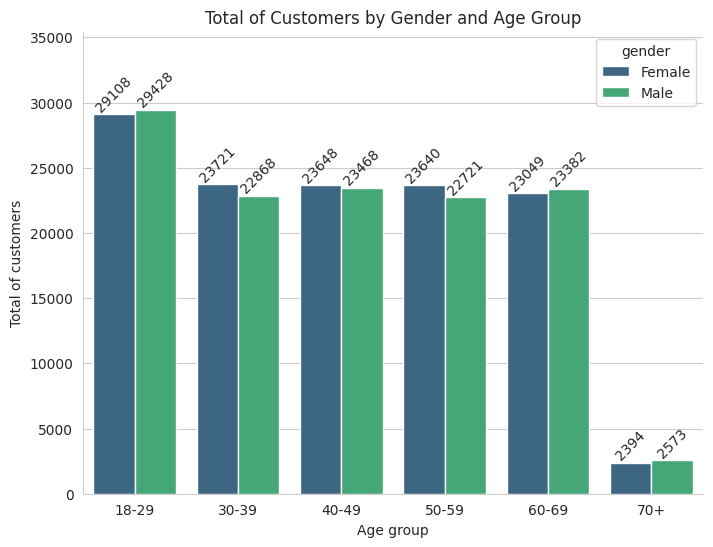

In [36]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=total_customers_by_age_group.to_pandas(),
             x='age_group',
             y='total',
             hue='gender',
             palette='viridis')
sns.despine()
plt.title('Total of Customers by Gender and Age Group')
plt.xlabel('Age group')
plt.ylabel('Total of customers')
top_lim = total_customers_by_age_group.select('total').max().to_series()[0] + 6000
plt.ylim(top=top_lim)

for i in ax.containers:
    ax.bar_label(i, rotation=45)
plt.show()

Based on the 'Total of Customers by Gender and Age Group' chart, the number of customers is greater among those aged 18-29 years old, remains relatively similar across the 30 to 69 years old age groups, and decreases significantly in the 70+ years old age group.

### How many products were sold by source and gender?

In [37]:
quantity_by_source_gender = sql.execute(
"""
SELECT
  source,
  gender,
  SUM(quantity) AS quantity
FROM ecommerce
GROUP BY source, gender
ORDER BY quantity DESC
""")

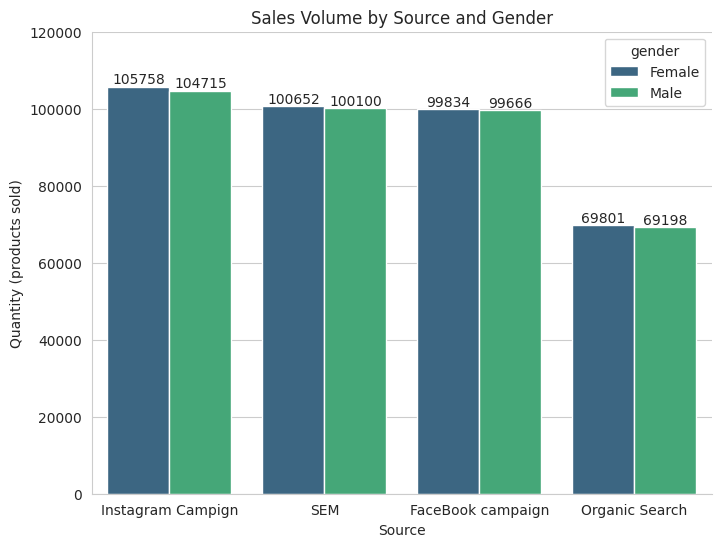

In [38]:
plt.figure(figsize=(8,6))

ax = sns.barplot(x="source", y="quantity", hue="gender",
                 palette='viridis',
                 data=quantity_by_source_gender.to_pandas())
plt.title("Sales Volume by Source and Gender")
plt.xlabel('Source')
plt.ylabel('Quantity (products sold)')
sns.despine()
plt.ylim(top=120000)

for i in ax.containers:
    ax.bar_label(i,)
plt.show()

**Chi-squared test for Revenue based on Gender and Source**

- Null hyphotesis: There is no association between gender and source.

- Alternative hyphotesis: There is an association between gender and source.

In [39]:
contingency_table = ecommerce_c.pivot(index="gender",
                                      columns='source',
                                      values="revenue",
                                      aggregate_function="len")

contingency_table = contingency_table.to_pandas().set_index('gender')
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha: # If 𝑝 -value < 𝛼: Reject 𝐻0​. Accept 𝐻1​.
    print("There is a statistically significant association between gender and source.")
else: # If 𝑝 -value ≥ 𝛼: Fail to reject 𝐻0​. No evidence to support 𝐻 1
    print("There is no statistically significant association between gender and source.")


Chi-squared statistic: 0.6067009705273644
P-value: 0.894896640452203
There is no statistically significant association between gender and source.


In [40]:
print(contingency_table)

        FaceBook campaign  Organic Search    SEM  Instagram Campign
gender                                                             
Male                33297           23090  33174              34879
Female              33476           23224  33569              35291


Based on the 'Sales Volume by Source and Gender' chart, the quantity of product sold by source and gender is relatively similar across all sources when we group it by gender. The Chi-Square Test of Independence confirms that there is no statistically significant association between gender and source.

### How many products were sold by product category and gender?

In [41]:
quantity_by_category_gender = sql.execute(
"""
SELECT
  product_category,
  gender,
  SUM(quantity) AS quantity
FROM ecommerce
GROUP BY product_category, gender
ORDER BY quantity DESC
""")

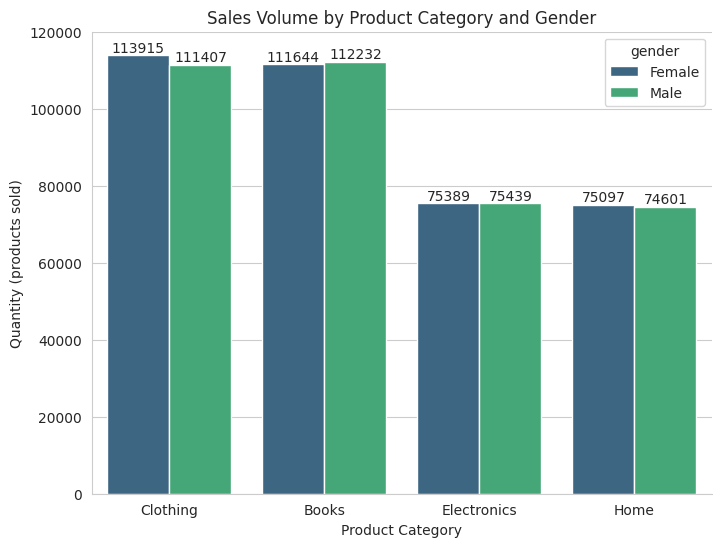

In [42]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="product_category", y="quantity", hue="gender",
                 palette='viridis',
                 data=quantity_by_category_gender.to_pandas())
sns.despine()
plt.title("Sales Volume by Product Category and Gender")
plt.xlabel('Product Category')
plt.ylabel('Quantity (products sold)')
plt.ylim(top=120000)

for i in ax.containers:
    ax.bar_label(i,)
plt.show()

**Chi-squared test for Revenue based on Gender and Product Category**  

- Null hyphotesis: There is no association between gender and product category.

- Alternative hyphotesis: There is an association between gender and product category.

In [43]:
contingency_table = ecommerce_c.pivot(index="gender",
                                      columns='product_category',
                                      values="revenue",
                                      aggregate_function="len")

contingency_table = contingency_table.to_pandas().set_index('gender')
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha: # If 𝑝 -value < 𝛼: Reject 𝐻0​. Accept 𝐻1​.
    print("There is a statistically significant association between gender and product category.")
else: # If 𝑝 -value ≥ 𝛼: Fail to reject 𝐻0​. No evidence to support 𝐻 1
    print("There is no statistically significant association between gender and product category.")


Chi-squared statistic: 5.114194769527462
P-value: 0.16362369173096045
There is no statistically significant association between gender and product category.


In [44]:
print(contingency_table)

        Clothing  Books  Electronics   Home
gender                                     
Male       37106  37439        25057  24838
Female     37946  37473        25128  25013


Based on the 'Sales Volume by Product Category and Gender' chart, the quantity of product sold by category and gender is relatively similar across all categories when we group it by gender. The Chi-Square Test of Independence confirms that there is no statistically significant association between gender and product category too.

### How many products were sold by product category and age group?

In [45]:
sales_by_category_age = sql.execute(
    """
    SELECT
      age_group,
      product_category,
      SUM(quantity) AS quantity
    FROM ecommerce
    GROUP BY age_group, product_category
    ORDER BY age_group ASC
    """
)

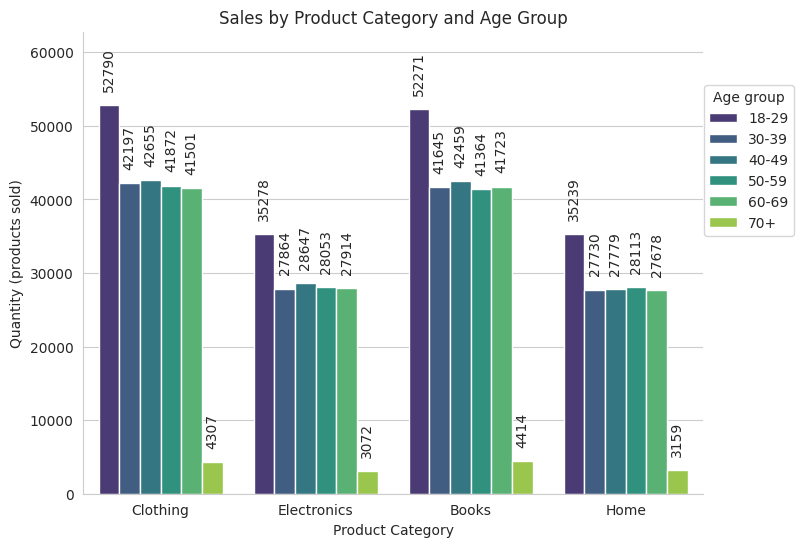

In [46]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=sales_by_category_age.to_pandas(),
             x='product_category',
             y='quantity',
             hue='age_group',
             palette='viridis')
sns.despine()
plt.title('Sales by Product Category and Age Group')
plt.xlabel('Product Category')
plt.ylabel('Quantity (products sold)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.99, .90), title='Age group')
top_lim = sales_by_category_age.select('quantity').max().to_series()[0] + 10000
plt.ylim(top=top_lim)
for i in ax.containers:
    ax.bar_label(i, rotation=90, padding=10)
plt.show()

Based on the 'Sales by Product Category and Age Group' chart, the quantity of product sold by product category and gender is greater among those between 18-29, relatively similar across  the 30 to 69 years old age groups and decreases significantly in the 70+ years old age group.

### How many products were sold by source and age group?

In [47]:
sales_by_source_age = sql.execute(
    """
    SELECT
      age_group,
      source,
      SUM(quantity) AS quantity
    FROM ecommerce
    GROUP BY age_group, source
    ORDER BY age_group ASC
    """
)

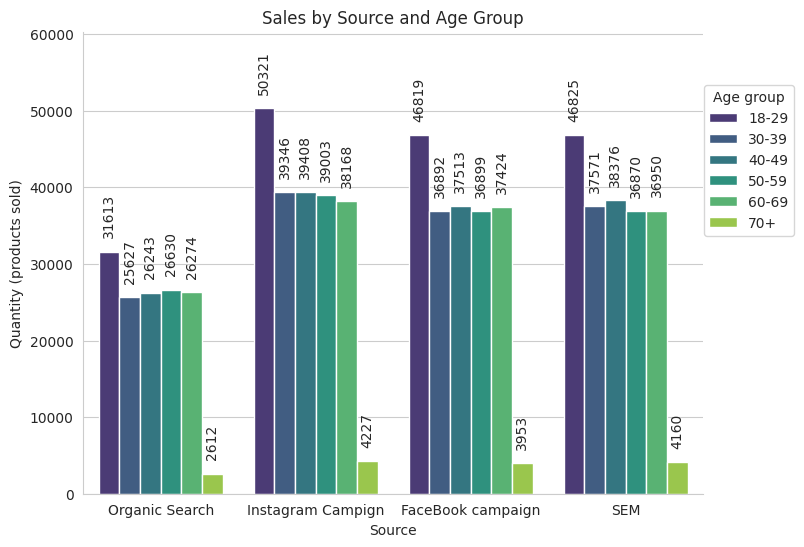

In [48]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=sales_by_source_age.to_pandas(),
             x='source',
             y='quantity',
             hue='age_group',
             palette='viridis')
sns.despine()
plt.title('Sales by Source and Age Group')
plt.xlabel('Source')
plt.ylabel('Quantity (products sold)')

top_lim = sales_by_source_age.select('quantity').max().to_series()[0] + 10000
plt.ylim(top=top_lim)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.99, .90), title='Age group')

for i in ax.containers:
    ax.bar_label(i, rotation=90, padding=10)
plt.show()

Based on the 'Sales by Source and Age Group' chart, the quantity of product sold by source and gender is greater among those between 18-29, relatively similar across  the 30 to 69 years old age groups and decreases significantly in the 70+ years old age group.

### How much revenue were generate by source and age group?

In [49]:
revenue_by_source_age = sql.execute(
    """
    SELECT
      age_group,
      source,
      ROUND(SUM(revenue), 2)/1000000 AS revenue
    FROM ecommerce
    GROUP BY age_group, source
    ORDER BY age_group ASC
    """
)

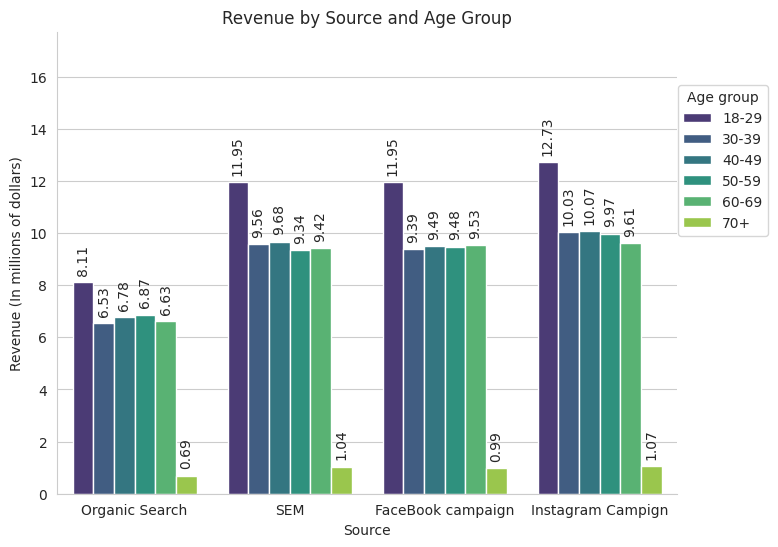

In [50]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=revenue_by_source_age.to_pandas(),
             x='source',
             y='revenue',
             hue='age_group',
             palette='viridis')
sns.despine()
plt.title('Revenue by Source and Age Group')
plt.xlabel('Source')
plt.ylabel('Revenue (In millions of dollars)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.99, .90), title='Age group')
top_lim = revenue_by_source_age.select(
    'revenue').max().to_series()[0] + 5
plt.ylim(top=top_lim)
for i in ax.containers:
    ax.bar_label(i, rotation=90, padding=5, fmt="%.2f")

plt.show()

**Chi-squared test for Revenue based on Age group and Source**

- Null hyphotesis: There is no association between age group and source.

- Alternative hyphotesis: There is an association between age group and source.

In [51]:
contingency_table = ecommerce_c.pivot(index='age_group',
                                      columns='source',
                                      values="revenue",
                                      aggregate_function="len")

contingency_table = contingency_table.to_pandas().set_index('age_group')
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha: # If 𝑝 -value < 𝛼: Reject 𝐻0​. Accept 𝐻1​.
    print("There is a statistically significant association between age group and source.")
else: # If 𝑝 -value ≥ 𝛼: Fail to reject 𝐻0​. No evidence to support 𝐻1
    print("There is no statistically significant association between age groups and source.")

Chi-squared statistic: 38.416900955101354
P-value: 0.0007827070119108014
There is a statistically significant association between age group and source.


In [52]:
print(contingency_table)

           FaceBook campaign  Organic Search    SEM  Instagram Campign
age_group                                                             
50-59                  12303            8841  12275              12942
40-49                  12468            8718  12732              13198
30-39                  12420            8565  12528              13076
60-69                  12590            8740  12298              12803
18-29                  15663           10568  15567              16738
70+                     1329             882   1343               1413


Based on the 'Revenue by Source and Age Group' chart, the revenue by source and gender is greater among those between 18-29, relatively similar across  the 30 to 69 years old age groups and decreases significantly in the 70+ years old age group. The Chi-Square Test of Independence confirms that there is a statistically significant association between source and age group for revenue.

### How much revenue were generate by product category and age group?

In [53]:
revenue_by_category_age = sql.execute(
    """
    SELECT
      age_group,
      product_category,
      ROUND(SUM(revenue), 2)/1000000 AS revenue
    FROM ecommerce
    GROUP BY age_group, product_category
    ORDER BY age_group ASC
    """
)

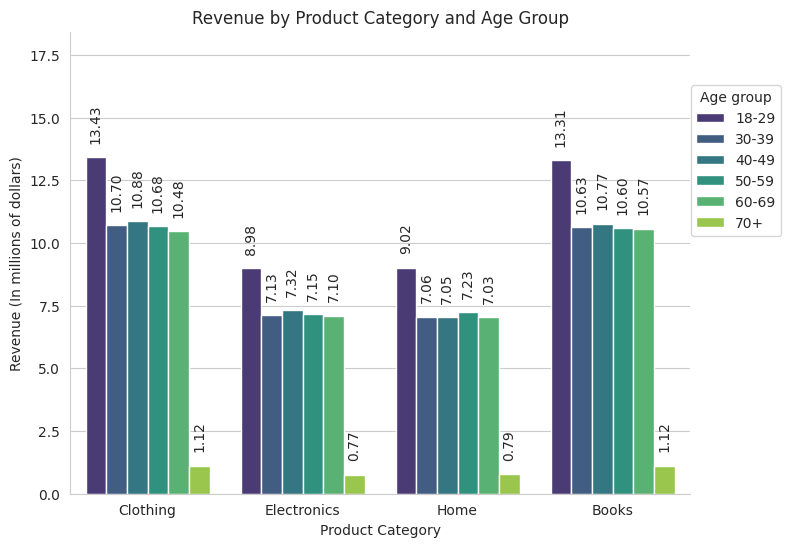

In [54]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=revenue_by_category_age.to_pandas(),
             x='product_category',
             y='revenue',
             hue='age_group',
             palette='viridis')
sns.despine()
plt.title('Revenue by Product Category and Age Group')
plt.xlabel('Product Category')
plt.ylabel('Revenue (In millions of dollars)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.99, .90), title='Age group')
top_lim = revenue_by_category_age.select('revenue').max().to_series()[0] + 5
plt.ylim(top=top_lim)
for i in ax.containers:
    ax.bar_label(i, rotation=90, padding=10, fmt="%.2f")

plt.show()

**Chi-squared test for Revenue based on Age group and Product Category**

- Null hyphotesis: There is no association between age group and Product Category.

- Alternative hyphotesis: There is an association between age group and Product Category.

In [55]:
contingency_table = ecommerce_c.pivot(index='age_group',
                                      columns='product_category',
                                      values="revenue",
                                      aggregate_function="len")

contingency_table = contingency_table.to_pandas().set_index('age_group')
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha: # If 𝑝 -value < 𝛼: Reject 𝐻0​. Accept 𝐻1​.
    print("There is a statistically significant association between age groups and Product Category.")
else: # If 𝑝 -value ≥ 𝛼: Fail to reject 𝐻0​. No evidence to support 𝐻 1
    print("There is no statistically significant association between age groups and Product Category.")

Chi-squared statistic: 11.989550914615034
P-value: 0.6798198027397353
There is no statistically significant association between age groups and Product Category.


In [56]:
print(contingency_table)

           Clothing  Books  Electronics   Home
age_group                                     
50-59         13882  13803         9341   9335
40-49         14121  14197         9488   9310
30-39         14138  13938         9242   9271
60-69         13872  14003         9329   9227
18-29         17590  17499        11731  11716
70+            1449   1472         1054    992


Based on the 'Revenue by Product Category and Age Group' chart, the revenue by product category gender is greater among those between 18-29, relatively similar across  the 30 to 69 years old age groups and decreases significantly in the 70+ years old age group. The Chi-Square Test of Independence shows that there is no statistically significant association between product category and age group for revenue.

### How many products were sold by source and product category?

In [57]:
sales_by_source_category = sql.execute(
    """
    SELECT
      source,
      product_category,
      SUM(quantity) AS quantity
    FROM ecommerce
    GROUP BY source, product_category
    """
)

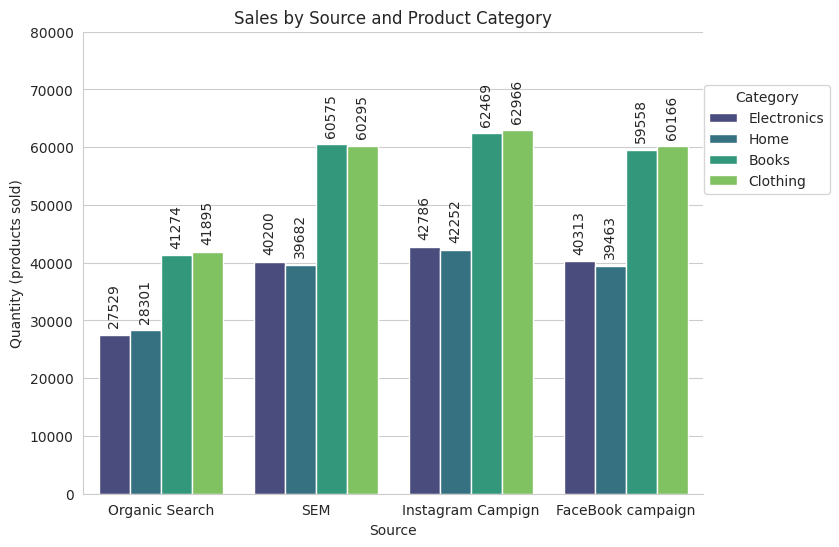

In [58]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="source",
                 y="quantity",
                 hue="product_category",
                 palette='viridis',
                 data=sales_by_source_category.to_pandas())
plt.title("Sales by Source and Product Category")
plt.xlabel('Source')
plt.ylabel('Quantity (products sold)')
sns.despine()
plt.ylim(top=80000)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.99, .90), title='Category')
for i in ax.containers:
    ax.bar_label(i, rotation=90, padding=5)
plt.show()

Based on the 'Sales by Source and Product Category' chart, the quantity of product sold by source and product category is relatively similar for clothing and book category and for home and eletronics across all sources.

### How much revenue were generate by source and product category?

In [59]:
revenue_by_source_category = sql.execute(
    """
    SELECT
      source,
      product_category,
      ROUND(SUM(revenue),2)/1000000 AS revenue
    FROM ecommerce
    GROUP BY source, product_category
    """
)

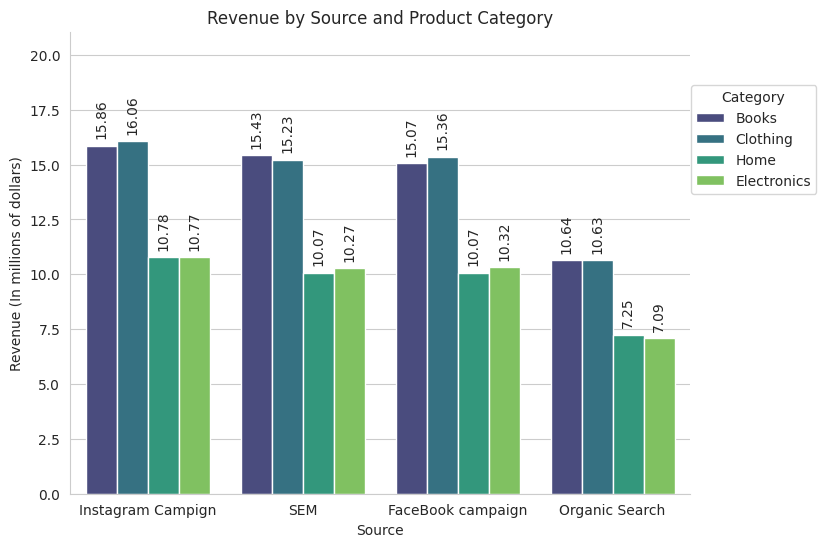

In [60]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="source",
                 y="revenue",
                 hue="product_category",
                 palette='viridis',
                 data=revenue_by_source_category.to_pandas())
plt.title("Revenue by Source and Product Category")
plt.xlabel('Source')
plt.ylabel('Revenue (In millions of dollars)')
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.99, .90), title='Category')
top_lim = revenue_by_source_category.select(
    'revenue').max().to_series()[0] + 5
plt.ylim(top=top_lim)
for i in ax.containers:
    ax.bar_label(i, rotation=90, padding=5, fmt="%.2f")
plt.show()

Based on the 'Revenue by Source and Product Category' chart, the revenue by source and product category is relatively similar for clothing and book category and for home and eletronics across all sources.

**Chi-squared test for Revenue based on Source and Product Category**

- Null hyphotesis: There is no association between product category and source.

- Alternative hyphotesis: There is an association between product category and source.

In [61]:
contingency_table = ecommerce_c.pivot(index='product_category',
                                      columns='source',
                                      values="revenue",
                                      aggregate_function="len")

contingency_table = contingency_table.to_pandas().set_index('product_category')
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha: # If 𝑝 -value < 𝛼: Reject 𝐻0​. Accept 𝐻1​.
    print("There is a statistically significant association between product category and source.")
else: # If 𝑝 -value ≥ 𝛼: Fail to reject 𝐻0​. No evidence to support 𝐻 1
    print("There is no statistically significant association between product category and source.")

Chi-squared statistic: 13.825465648217591
P-value: 0.12867060967583924
There is no statistically significant association between product category and source.


In [62]:
print(contingency_table)

                  FaceBook campaign  Organic Search    SEM  Instagram Campign
product_category                                                             
Clothing                      20111           13984  20049              20908
Books                         19951           13798  20226              20937
Electronics                   13452            9174  13326              14233
Home                          13259            9358  13142              14092


 The Chi-Square Test of Independence shows that there is no statistically significant association between product category and source for revenue.

### Age Box-plot analysis by product category and source


<Figure size 800x600 with 0 Axes>

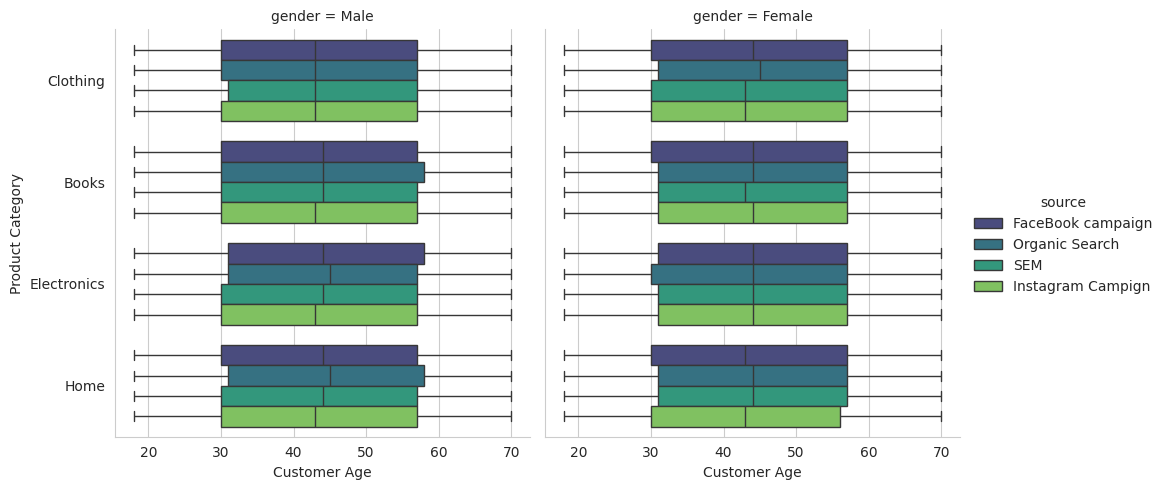

In [63]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.catplot(x='customer_age', y='product_category',
            hue='source',
            palette='viridis',
            col='gender',
            data=ecommerce_c.to_pandas(),
            kind='box',
)
ax.set(xlabel="Customer Age", ylabel="Product Category")
plt.show()

The box plot analysis reveals a similar mean ages across all combinations of product category and source for both genders. This consistency suggests that age may not be a significant differentiating factor in consumer behavior across various product categories and sources among both gender.

### Two-way ANOVA test for Revenue based on Product Category and Source

In [64]:
# Perform two-way ANOVA for 'revenue' based on 'product_category' and 'source'
model = ols('revenue ~ C(product_category) + C(source) + C(product_category):C(source)',
            data=ecommerce_c.to_pandas()).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Two-way ANOVA results for Revenue based on Product Category and Source:")
print(anova_table)

Two-way ANOVA results for Revenue based on Product Category and Source:
                                     sum_sq        df         F    PR(>F)
C(product_category)            1.142100e+06       3.0  1.087692  0.352817
C(source)                      1.897568e+06       3.0  1.807171  0.143412
C(product_category):C(source)  4.477103e+06       9.0  1.421273  0.172279
Residual                       8.749621e+10  249984.0       NaN       NaN


Based on the results of Two-way ANOVA test for the effect of Product Category and Source on Revenue:

- The p-value is 0.352817, which is greater than the significance level of 0.05. This suggests that the main effect of 'Product Category' is not statistically significant on 'Revenue'.

- The p-value associated with 'Source' is 0.143412, which is greater than 0.05. Thus, the main effect of 'Source' is not statistically significant on 'Revenue'.

- The p-value for the interaction effect is 0.172279, which is greater than 0.05. Thus, the interaction effect between 'Product Category' and 'Source' is not statistically significant on 'Revenue'.

## Conclusion

- In average the home category has slightly the best satisfaction factor of the customer (NPS). So, we can not conclude what product category have the best NPS just by the mean.
- Some charts shows that the volume of products sold (quantity) are very similar when we group sales quantity by gender. Even thought the best-performant source was Instagram for both gender there is no statistically significant association between gender and source.
- In terms of product category clothing and book category were the best-performant for both gender but there is no statistically significant association between gender and product category.
- The analysis of source and age group shows that we have a greater volume among those between 18-29, relatively similar across the 30 to 69 years old age groups and decreases significantly in the 70+ years old age group for both revenue and quantity of product sold. The Chi-Square Test of Independence confirmed that there is a statistically significant association between source and age group for revenue but not for product category and age group.
- The analysis of product sold (quantity) and revenue by source and product category reveals that Instagram and SEM were the best-performant sources, but the Chi-Square Test of Independence elucidates that there is no statistically significant association between product category and source for revenue.
- Based on the box-plot analysis for both gender we can conclude that that age may not be a significant differentiating factor in consumer behavior across various product categories and sources.
- We also can conclude based on the two-way ANOVA that both product category and source were not statiscally significant on revenue.
- Therefore assuming the limitations of the dataset and the information we have about customers we should try to find new features which could reveal our customer behavior and, so, make better decisions about source and proeduct category recomendation based on customers gender and age group.